In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

import json

In [ ]:
orders = json.load(open("../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/2_orders.json")) 
initial_fill = json.load(open("../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/3_initial_fill_lvl.json"))

In [ ]:
len(initial_fill.keys())

In [ ]:
len(orders)

In [ ]:
order_columns = ['type', 'sku', 'time', 'dock', 'batch', 'week']
order_df = pd.DataFrame(orders, columns=order_columns)

# Sort the orders by time
order_df = order_df.sort_values(by='time').reset_index(drop=True)

# Calculate the time difference between consecutive orders
order_df['time_diff'] = order_df['time'].diff()

# Define a threshold for breaks (e.g., 1200 seconds for a 20-minute break)
threshold = 1200

# Identify breaks
breaks = order_df[order_df['time_diff'] > threshold]

# Display the breaks
print(breaks[['time', 'time_diff']])

In [ ]:
len(orders)

In [ ]:
def process_orders_by_week(orders, initial_fill):
    # Create a DataFrame from the orders
    order_columns = ['type', 'sku', 'time', 'dock', 'batch', 'week']
    order_df = pd.DataFrame(orders, columns=order_columns)
    order_df['day'] = order_df['time'] // (24 * 3600)
    
    # Initialize the fill levels from the initial fill data
    fill_levels = initial_fill.copy()

    # Store fill levels at the beginning of each week
    weekly_fill_levels = {}

    # Process orders week by week
    for week in sorted(order_df['week'].unique()):
        # Get orders for the current week
        weekly_orders = order_df[order_df['week'] == week]
        
        # Store the fill level at the beginning of the week
        weekly_fill_levels[week] = fill_levels.copy()
        
        # Process each order for the current week
        for _, order in weekly_orders.iterrows():
            order_type, sku = order['type'], str(order['sku'])
            
            # For delivery, increase the stock of the SKU
            if order_type == "delivery":
                fill_levels[sku] = fill_levels.get(sku, 0) + 1
            # For retrieval, decrease the stock of the SKU
            elif order_type == "retrieval":
                fill_levels[sku] = fill_levels.get(sku, 0) - 1

    return weekly_fill_levels, order_df

# Process the orders and calculate weekly fill levels
weekly_fill_levels, order_df = process_orders_by_week(orders, initial_fill)

# Print the fill levels at the beginning of each week
for week, fill in weekly_fill_levels.items():
    print(f"Week {week}: Fill levels: {fill}")

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize hourly stock movements (deliveries and retrievals)
def visualize_hourly_stock_movements(weekly_fill_levels, order_df, week=1):
    # Filter the orders for the given week and get the unique hours within this week
    first_week_orders = order_df[order_df['week'] == week]
    first_week_orders['hour'] = order_df['time'] // 3600  # Convert time to hours
    hours_in_week = sorted(first_week_orders['hour'].unique())

    # Initialize fill levels for aggregation at the start of the week
    fill_levels_at_start = weekly_fill_levels[week].copy()

    # Store the hourly changes in stock
    hourly_delivery_movements = []
    hourly_retrieval_movements = []
    
    # Process each hour within the week
    for hour in hours_in_week:
        hour_orders = first_week_orders[first_week_orders['hour'] == hour]

        # Track delivery and retrieval counts for the hour
        hourly_deliveries = 0
        hourly_retrievals = 0

        # Process each order within the hour
        for _, order in hour_orders.iterrows():
            order_type, sku = order['type'], str(order['sku'])
            if order_type == "delivery":
                hourly_deliveries += 1
                fill_levels_at_start[sku] = fill_levels_at_start.get(sku, 0) + 1
            elif order_type == "retrieval":
                hourly_retrievals += 1
                fill_levels_at_start[sku] = fill_levels_at_start.get(sku, 0) - 1

        # Append the hourly movements (deliveries and retrievals)
        hourly_delivery_movements.append(hourly_deliveries)
        hourly_retrieval_movements.append(hourly_retrievals)
    
    # Plot the hourly stock movements (deliveries and retrievals)
    plt.figure(figsize=(14, 6))
    plt.plot(hours_in_week, hourly_delivery_movements, label="Hourly Deliveries", color='g', marker='o')
    plt.plot(hours_in_week, hourly_retrieval_movements, label="Hourly Retrievals", color='r', marker='o')

    plt.title("Hourly Stock Movements (Deliveries and Retrievals) - First Week")
    plt.xlabel("Hour")
    plt.ylabel("Number of Movements")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Example usage:
# Call visualize_hourly_stock_movements with the data processed

In [ ]:
visualize_hourly_stock_movements(weekly_fill_levels, order_df, week=1)

In [ ]:
visualize_hourly_stock_movements(weekly_fill_levels, order_df, week=14)

In [ ]:
def process_orders_by_day(orders, initial_fill):
    # Create a DataFrame from the orders
    if len(orders[0]) == 6:
        order_columns = ['type', 'sku', 'time', 'dock', 'batch', 'week']
    else:
        order_columns = ['type', 'sku', 'time', 'dock', 'batch', 'week', 'destination']
        
    order_df = pd.DataFrame(orders, columns=order_columns)
    
    # Calculate the day number and hour within day
    order_df['day'] = order_df['time'] // (24 * 3600)
    order_df['hour'] = (order_df['time'] % (24 * 3600)) // 3600
    
    # Initialize the fill levels from the initial fill data
    fill_levels = initial_fill.copy()

    # Store fill levels at the beginning of each day
    daily_fill_levels = {}
    daily_changes = {}

    # Process orders day by day
    for day in sorted(order_df['day'].unique()):
        # Get orders for the current day
        daily_orders = order_df[order_df['day'] == day]
        
        # Store the fill level at the beginning of the day
        daily_fill_levels[day] = fill_levels.copy()
        
        # Initialize daily changes tracking
        daily_changes[day] = {
            'deliveries': {},
            'retrievals': {},
            'net_change': {},
            'total_deliveries': 0,
            'total_retrievals': 0
        }
        
        # Process each order for the current day
        for _, order in daily_orders.iterrows():
            order_type, sku = order['type'], str(order['sku'])
            
            # Track changes for the current SKU
            if sku not in daily_changes[day]['deliveries']:
                daily_changes[day]['deliveries'][sku] = 0
                daily_changes[day]['retrievals'][sku] = 0
                daily_changes[day]['net_change'][sku] = 0
            
            # Update fill levels and track changes
            if order_type == "delivery":
                fill_levels[sku] = fill_levels.get(sku, 0) + 1
                daily_changes[day]['deliveries'][sku] += 1
                daily_changes[day]['total_deliveries'] += 1
            elif order_type == "retrieval":
                fill_levels[sku] = fill_levels.get(sku, 0) - 1
                daily_changes[day]['retrievals'][sku] += 1
                daily_changes[day]['total_retrievals'] += 1
            
            # Update net change
            daily_changes[day]['net_change'][sku] = (
                daily_changes[day]['deliveries'][sku] - 
                daily_changes[day]['retrievals'][sku]
            )

    # Add summary statistics for each day
    for day in daily_changes:
        daily_changes[day]['summary'] = {
            'unique_skus': len(daily_changes[day]['net_change']),
            'net_movement': (daily_changes[day]['total_deliveries'] - 
                           daily_changes[day]['total_retrievals']),
            'start_total': sum(daily_fill_levels[day].values()),
            'end_total': (sum(daily_fill_levels[day].values()) + 
                         daily_changes[day]['total_deliveries'] - 
                         daily_changes[day]['total_retrievals'])
        }

    return daily_fill_levels, daily_changes, order_df

def visualize_daily_stock_movements(daily_fill_levels, order_df, day=1):
    # Filter the orders for the given day and get the unique hours within this day
    daily_orders = order_df[order_df['day'] == day]
    daily_orders['hour'] = order_df['time'] % 86400 // 3600  # Convert time to hours within day (0-23)
    hours_in_day = list(range(24))  # Show all 24 hours
    
    # Initialize fill levels for aggregation at the start of the day
    fill_levels_at_start = daily_fill_levels[day].copy()
    
    # Store the hourly changes in stock
    hourly_delivery_movements = [0] * 24  # Initialize with zeros for all 24 hours
    hourly_retrieval_movements = [0] * 24  # Initialize with zeros for all 24 hours
    
    # Process each hour's orders
    for _, order in daily_orders.iterrows():
        hour = order['hour']
        order_type, sku = order['type'], str(order['sku'])
        
        if order_type == "delivery":
            hourly_delivery_movements[hour] += 1
            fill_levels_at_start[sku] = fill_levels_at_start.get(sku, 0) + 1
        elif order_type == "retrieval":
            hourly_retrieval_movements[hour] += 1
            fill_levels_at_start[sku] = fill_levels_at_start.get(sku, 0) - 1
    
    # Create the visualization
    plt.figure(figsize=(14, 6))
    
    # Plot bars instead of lines for better visibility of hourly data
    x = range(24)
    width = 0.35
    
    # plt.bar([i - width/2 for i in x], hourly_delivery_movements, width, 
    #         label="Hourly Deliveries", color='g', alpha=0.7)
    plt.plot([i + width/2 for i in x], hourly_retrieval_movements, width,
            label="Hourly Retrievals", color='r', alpha=0.7)
    
    plt.title(f"Daily Stock Movements (Deliveries and Retrievals) - Day {day}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Movements")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Customize x-axis to show all 24 hours
    plt.xticks(range(24))
    
    # Add total movements as text annotation
    total_deliveries = sum(hourly_delivery_movements)
    total_retrievals = sum(hourly_retrieval_movements)
    plt.text(0.02, 0.95, f'Total Deliveries: {total_deliveries}\nTotal Retrievals: {total_retrievals}',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()
    
    return {
        'total_deliveries': total_deliveries,
        'total_retrievals': total_retrievals,
        'net_change': total_deliveries - total_retrievals,
        'hourly_delivery_movements': hourly_delivery_movements,
        'hourly_retrieval_movements': hourly_retrieval_movements
    }
daily_fill_levels, daily_changes, order_df = process_orders_by_day(orders, initial_fill)

In [ ]:
daily_stats = visualize_daily_stock_movements(daily_fill_levels, order_df, day=3)

In [ ]:
def plot_hourly_retrievals_for_all_days(daily_changes, order_df):
    # Initialize an array to store the hourly retrievals across all days (24 hours)
    hourly_retrievals_all_days = np.zeros(24)  # 24 hours in a day
    
    # Process each day's retrievals
    for day in daily_changes:
        # Extract the retrieval movements for the current day
        hourly_retrievals = [0] * 24
        
        # Filter orders for the current day and calculate hourly retrievals
        daily_orders = order_df[order_df['day'] == day]
        for _, order in daily_orders.iterrows():
            if order['type'] == 'retrieval':
                hour = order['hour']
                hourly_retrievals[hour] += 1
        
        # Add the hourly retrievals to the overall total
        hourly_retrievals_all_days += hourly_retrievals
    
    # Calculate the average hourly retrievals across all days
    hourly_retrievals_avg = hourly_retrievals_all_days / len(daily_changes)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(range(24), hourly_retrievals_avg, marker='o', color='blue', label="Average Hourly Retrievals", linestyle='-', alpha=0.7)
    
    # Add title and labels
    plt.title("Average Hourly Retrievals Across All Days", fontsize=14)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Average Retrievals", fontsize=12)
    
    # Customize plot appearance
    plt.xticks(range(24))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage
plot_hourly_retrievals_for_all_days(daily_changes, order_df)

In [ ]:
for day in order_df[order_df["week"]==7].day.unique():
    daily_stats = visualize_daily_stock_movements(daily_fill_levels, order_df, day=day)

In [ ]:
order_df[order_df["day"]==43]

In [ ]:
order_df.groupby(by="day").count() 

In [ ]:
order_df[order_df["week"]==4].day.unique()

In [ ]:
order_df.groupby(by="week").count() 

In [ ]:
i = 0
print(len(orders))
orders_new = []
for order in orders:
    if i < 20000:
        orders_new.append(order)
    else:
        break
    i += 1

In [ ]:
len(orders_new)

In [ ]:
#del orders_new[300000:320000]

In [ ]:
json.dump(orders_new, open("../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/2_orders.json", "w"))

# Layout

In [ ]:
use_case = "wepastacks"

In [ ]:
use_case


In [ ]:
layout = pd.read_csv(f"../1_environment/slapstack/slapstack/use_cases/{use_case}/1_layout.csv", header=None, delimiter=",").values

In [ ]:
layout

In [ ]:
layout.dropna(axis=1, how='all', inplace=True)

In [ ]:
plt.imshow(layout)

In [ ]:
n_pallets = layout[layout == 0].shape[0]
ref_col = layout[:,20]
# explanation aisle dim: WEPA forklifts carry 4 pallets in a 2x2 grid --> width for loaded forklift >= 80 * 2;
# + bidirectional aisle --> 1600 * 2 = 3.2m + 20 cm safety buffer --> 3.4
max_width = ref_col[ref_col == 0].shape[0] * 1.4 + ref_col[np.isin(ref_col, [-5])].shape[0] * 3.4
ref_row = layout[10,:]
# https://www.richter-gabelstapler.com/de/shop/b2c/anbaugeraete/doppelpalettengabel-dpk-c-fem4.html
max_length = ref_row[ref_row == 0].shape[0]  * 1 + ref_col[np.isin(ref_col, [-5])].shape[0] * 3.4

In [ ]:
n_pallets * 3

In [ ]:
layout.shape[0] * layout.shape[1]

In [ ]:
layout.shape[1]

In [ ]:
n_pallets

In [ ]:
# n*a = √(SlNs/4SwA)
from math import sqrt
n_aisles = sqrt(layout.shape[1] * 120 / 4 * layout.shape[0] * 3)

In [ ]:
n_aisles

In [ ]:
import math
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

@dataclass
class SKU:
    """Represents a stock keeping unit with its properties"""
    id: str
    production_rate: float  # Pi (pallets per unit time)
    demand_rate: float      # λi (pallets per unit time)
    batch_quantity: float   # Qi (pallets)
    pallet_height: float    # Hi (units of distance)
    stackable_height: int   # Zi (in pallets)

@dataclass
class Warehouse:
    """Represents warehouse properties"""
    length: float           # Sl (in pallet units)
    width: float            # Sw (in pallet units)
    height: float           # Sh (units of distance)
    aisle_width: float      # A (in pallet units)
    cross_aisle_width: float  # C (in pallet units)

class WarehouseOptimizer:
    """Implements core analytical models from the paper"""
    
    def __init__(self, warehouse: Warehouse, n_skus):
        self.warehouse = warehouse
        # self.skus = skus
        self.num_skus = n_skus
    
    def optimal_number_of_aisles(self) -> float:
        """
        Implements Lemma 1: Calculate the optimal number of aisles
        n*a = √(SlNs/4SwA)
        """
        Sl = self.warehouse.length
        Ns = self.num_skus
        Sw = self.warehouse.width
        A = self.warehouse.aisle_width
        
        n_a_star = math.sqrt((Sl * Ns) / (4 * Sw * A))
        return n_a_star
    
    def get_integer_optimal_aisles(self) -> int:
        """
        Find the integer optimal number of aisles by evaluating
        the waste function at the floor and ceiling of n*a
        """
        n_a_star = self.optimal_number_of_aisles()
        n_a_floor = math.floor(n_a_star)
        n_a_ceil = math.ceil(n_a_star)
        
        # Calculate waste for both floor and ceiling values
        # waste_floor = self.calculate_waste_for_aisles(n_a_floor)
        # waste_ceil = self.calculate_waste_for_aisles(n_a_ceil)
        
        # Return the one with the least waste
        return n_a_floor # if waste_floor <= waste_ceil else n_a_ceil
    
    def optimal_bay_depth(self, n_a: float) -> float:
        """
        Calculate the optimal common bay depth
        x̄* = (Sl - n*aA)/(2n*a)
        """
        Sl = self.warehouse.length
        A = self.warehouse.aisle_width
        
        x_bar_star = (Sl - n_a * A) / (2 * n_a)
        return x_bar_star
    
    # def calculate_waste_for_aisles(self, n_a: int) -> float:
    #     """
    #     Calculate the waste for a given number of aisles
    #     Used for determining the integer optimal number of aisles
    #     """
    #     Sl = self.warehouse.length
    #     Sw = self.warehouse.width
    #     Sh = self.warehouse.height
    #     A = self.warehouse.aisle_width
    #     
    #     # Calculate common bay depth for this number of aisles
    #     x_bar = self.optimal_bay_depth(n_a)
    #     
    #     # First part: space dedicated to aisles
    #     aisle_waste = A * Sh * Sw * n_a
    #     
    #     # Second part: space from bay depths
    #     bay_depth_waste = (Sh / 2) * self.num_skus * x_bar
    #     
    #     # Third part: waste from honeycombing (simplified from equation 2 in paper)
    #     honeycombing_waste = sum(
    #         (1 / (2 * sku.production_rate * sku.stackable_height)) *
    #         ((sku.batch_quantity * (Sh - sku.stackable_height * sku.pallet_height) 
    #           - sku.stackable_height * sku.pallet_height) * (sku.production_rate - sku.demand_rate)
    #          - sku.demand_rate * (2 * Sh - sku.stackable_height * sku.pallet_height))
    #         for sku in self.skus
    #     )
    #     
    #     total_waste = aisle_waste + bay_depth_waste + honeycombing_waste
    #     return total_waste

warehouse = Warehouse(
        length=layout.shape[1],  # Length in pallet units
        width=layout.shape[0],   # Width in pallet units
        height=3,   # Height in distance units
        aisle_width=2,  # Aisle width in pallet units
        cross_aisle_width=1  # Cross-aisle width in pallet units
    )

optimizer = WarehouseOptimizer(warehouse, 62)
n_a_star = optimizer.optimal_number_of_aisles()
n_a_int = optimizer.get_integer_optimal_aisles()
print(f"Optimal number of aisles (theoretical): {n_a_star:.2f}")
print(f"Optimal number of aisles (integer): {n_a_int}")

x_bar_star = optimizer.optimal_bay_depth(n_a_int)
print(f"Optimal bay depth: {x_bar_star:.2f} pallet positions")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict, namedtuple
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Any, Callable
import math
import random
import time
from enum import Enum


#------------------------------------------------------------
# Event Queue System (replacing SimPy functionality)
#------------------------------------------------------------

class EventQueue:
    """Custom priority queue for events, ordered by scheduled time"""
    
    def __init__(self):
        self.queue = []  # List of (time, priority, event_id, event_handler, args, kwargs)
        self.event_counter = 0  # Counter to break ties for events at the same time
    
    def schedule(self, time: float, handler: Callable, *args, priority: int = 1, **kwargs):
        """Schedule an event at the specified time"""
        event_id = self.event_counter
        self.event_counter += 1
        heapq.heappush(self.queue, (time, priority, event_id, handler, args, kwargs))
    
    def run(self, until: float = float('inf')):
        """Run the simulation until the specified time"""
        current_time = 0
        
        while self.queue and current_time <= until:
            # Get the next event
            time, _, _, handler, args, kwargs = heapq.heappop(self.queue)
            
            # Update current time
            current_time = time
            
            if current_time > until:
                # Put the event back and break
                heapq.heappush(self.queue, (time, _, _, handler, args, kwargs))
                break
            
            # Execute the event handler
            handler(*args, time=current_time, **kwargs)
        
        return current_time
    
    def clear(self):
        """Clear all scheduled events"""
        self.queue = []


#------------------------------------------------------------
# Data Structures
#------------------------------------------------------------

class VehicleStatus(Enum):
    """Status of a material handling vehicle"""
    IDLE = 0
    TRAVELING_EMPTY = 1
    LOADING = 2
    TRAVELING_LOADED = 3
    UNLOADING = 4


class PalletStatus(Enum):
    """Status of a pallet in the warehouse"""
    PRODUCED = 0      # Just produced, waiting for transport
    IN_TRANSIT = 1    # Being transported
    STORED = 2        # Stored in a lane
    RETRIEVED = 3     # Retrieved from storage, waiting for outbound
    SHIPPED = 4       # Shipped out


@dataclass
class SKU:
    """Represents a stock keeping unit with its properties"""
    id: str
    production_rate: float      # Pi (pallets per unit time)
    demand_rate: float          # λi (pallets per unit time)
    batch_quantity: float       # Qi (pallets)
    pallet_height: float        # Hi (units of distance)
    stackable_height: int       # Zi (in pallets)
    production_cv: float = 0.2  # Coefficient of variation for production rate
    demand_cv: float = 0.3      # Coefficient of variation for demand rate
    batch_cv: float = 0.1       # Coefficient of variation for batch quantity


@dataclass
class Position:
    """Represents a position in the warehouse"""
    x: float
    y: float


@dataclass
class Warehouse:
    """Represents warehouse properties"""
    length: float              # Sl (in units of distance)
    width: float               # Sw (in units of distance)
    height: float              # Sh (units of distance)
    aisle_width: float         # A (in units of distance)
    cross_aisle_width: float   # C (in units of distance)
    num_aisles: int            # Number of aisles
    num_cross_aisles: int      # Number of cross-aisles
    bay_depth: int             # Bay depth in pallet positions
    bidirectional_cross_aisles: bool = False  # If True, cross-aisles are bidirectional
    
    # Positions of key areas
    production_lines: List[Position] = None
    outbound_docks: List[Position] = None
    vehicle_parking: Position = None
    
    # Operational parameters
    vehicle_speed: float = 2.0          # Average speed in distance units per time unit
    vehicle_speed_cv: float = 0.1       # Coefficient of variation for vehicle speed
    loading_time: float = 0.5          # Time to load/unload a pallet
    loading_time_cv: float = 0.2        # Coefficient of variation for loading time
    
    def __post_init__(self):
        """Initialize default positions if not provided"""
        if self.production_lines is None:
            # Create production lines along the left side of the warehouse
            self.production_lines = [
                Position(x=0, y=self.width * (i + 1) / (4 + 1))
                for i in range(4)
            ]
        
        if self.outbound_docks is None:
            # Create outbound docks along the right side of the warehouse
            self.outbound_docks = [
                Position(x=self.length, y=self.width * (i + 1) / (4 + 1))
                for i in range(4)
            ]
        
        if self.vehicle_parking is None:
            # Create vehicle parking at the bottom of the warehouse
            self.vehicle_parking = Position(x=self.length / 2, y=0)


class Lane:
    """Represents a storage lane in the warehouse"""
    
    def __init__(self, id: int, bay_id: int, x: float, y: float, depth: int, 
                 max_height: int, lane_width: float = 1.0):
        self.id = id
        self.bay_id = bay_id
        self.position = Position(x=x, y=y)  # Position of the front of the lane
        self.depth = depth
        self.max_height = max_height
        self.width = lane_width
        self.contents = []  # List of Pallet objects stored in the lane
        self.sku_id = None  # SKU currently stored in the lane
        self.reserved = False  # Whether the lane is reserved for upcoming pallets
    
    @property
    def is_empty(self) -> bool:
        """Return True if the lane has no pallets"""
        return len(self.contents) == 0
    
    @property
    def is_full(self) -> bool:
        """Return True if the lane is fully occupied"""
        return len(self.contents) >= self.depth * self.max_height
    
    @property
    def occupancy(self) -> float:
        """Return the occupancy rate of the lane"""
        return len(self.contents) / (self.depth * self.max_height)
    
    @property
    def available_positions(self) -> int:
        """Return the number of available positions in the lane"""
        return self.depth * self.max_height - len(self.contents)
    
    def can_store(self, pallet) -> bool:
        """
        Check if the lane can store the given pallet
        A lane can store a pallet if:
        1. It's empty, or
        2. It contains pallets of the same SKU and has available space
        """
        if self.is_empty:
            return True
        
        if self.sku_id == pallet.sku_id and not self.is_full:
            return True
        
        return False
    
    def store_pallet(self, pallet) -> bool:
        """
        Store a pallet in the lane
        Returns True if successful, False otherwise
        """
        if not self.can_store(pallet):
            return False
        
        if self.is_empty:
            self.sku_id = pallet.sku_id
        
        self.contents.append(pallet)
        pallet.status = PalletStatus.STORED
        pallet.position = self.position
        pallet.lane_id = self.id
        
        return True
    
    def retrieve_pallet(self) -> Optional[Any]:
        """
        Retrieve a pallet from the lane (LIFO policy)
        Returns the pallet if successful, None otherwise
        """
        if self.is_empty:
            return None
        
        pallet = self.contents.pop()
        
        # If lane is now empty, clear the SKU ID
        if self.is_empty:
            self.sku_id = None
            self.reserved = False
        
        return pallet
    
    def calculate_honeycombing_waste(self) -> float:
        """
        Calculate the honeycombing waste in the lane
        Honeycombing waste occurs when a lane is partially filled
        """
        if self.is_empty or self.is_full:
            return 0
        
        # Calculate the waste as the unfilled positions in the lane
        return self.available_positions
    
    def get_storage_position(self) -> Position:
        """Return the position where the next pallet should be stored"""
        # In real implementation, would calculate the exact position based on contents
        return self.position


class Pallet:
    """Represents a pallet in the warehouse"""
    
    def __init__(self, id: int, sku_id: str, time_created: float):
        self.id = id
        self.sku_id = sku_id
        self.time_created = time_created
        self.status = PalletStatus.PRODUCED
        self.position = None  # Current position
        self.lane_id = None   # ID of the lane where the pallet is stored
        self.time_stored = None
        self.time_retrieved = None
        self.time_shipped = None
    
    @property
    def storage_time(self) -> Optional[float]:
        """Return how long the pallet was stored"""
        if self.time_stored is None or self.time_retrieved is None:
            return None
        return self.time_retrieved - self.time_stored
    
    @property
    def total_time(self) -> Optional[float]:
        """Return the total time from creation to shipment"""
        if self.time_created is None or self.time_shipped is None:
            return None
        return self.time_shipped - self.time_created


class Vehicle:
    """Represents a material handling vehicle (forklift) in the warehouse"""
    
    def __init__(self, id: int, warehouse: Warehouse):
        self.id = id
        self.warehouse = warehouse
        self.position = warehouse.vehicle_parking  # Start at parking
        self.status = VehicleStatus.IDLE
        self.loaded_pallet = None
        self.is_busy = False  # Whether the vehicle is currently performing a task
        
        # Statistics
        self.total_distance_empty = 0
        self.total_distance_loaded = 0
        self.total_operations = 0
        self.busy_time = 0
        self.idle_time = 0
        self.utilization_samples = []
        self.last_status_change = 0
        self.last_time_update = 0
    
    def calculate_travel_time(self, destination: Position) -> float:
        """
        Calculate the travel time to the destination
        Accounts for speed variation and cross-aisles
        """
        # Calculate rectilinear distance
        dx = abs(destination.x - self.position.x)
        dy = abs(destination.y - self.position.y)
        distance = dx + dy
        
        # Add the travel time including variation
        speed = self.warehouse.vehicle_speed * np.random.normal(1, self.warehouse.vehicle_speed_cv)
        travel_time = distance / max(0.1, speed)  # Avoid division by zero
        
        # Update statistics
        if self.status == VehicleStatus.TRAVELING_LOADED:
            self.total_distance_loaded += distance
        else:
            self.total_distance_empty += distance
        
        return travel_time
    
    def update_position(self, new_position: Position):
        """Update the vehicle's position"""
        self.position = new_position
    
    def update_status(self, new_status: VehicleStatus, current_time: float):
        """Update the vehicle's status and record time in previous status"""
        if self.status != new_status:
            time_in_status = current_time - self.last_status_change
            
            if self.status == VehicleStatus.IDLE:
                self.idle_time += time_in_status
            else:
                self.busy_time += time_in_status
            
            # Sample utilization periodically
            if int(current_time) > int(self.last_status_change):
                utilization = self.busy_time / (self.busy_time + self.idle_time) if (self.busy_time + self.idle_time) > 0 else 0
                self.utilization_samples.append((current_time, utilization))
            
            self.status = new_status
            self.last_status_change = current_time
    
    def get_utilization(self) -> float:
        """Return the current utilization rate of the vehicle"""
        total_time = self.busy_time + self.idle_time
        return self.busy_time / total_time if total_time > 0 else 0


class WarehouseLayout:
    """Manages the physical layout of the warehouse"""
    
    def __init__(self, warehouse: Warehouse):
        self.warehouse = warehouse
        self.lanes = []
        self.cross_aisles = []
        self.aisles = []
        self.distance_matrix = {}  # Cache for distances between positions
        
        # Create the layout
        self._create_lanes()
        self._create_aisles()
        self._create_cross_aisles()
    
    def _create_lanes(self):
        """Create lanes based on warehouse parameters"""
        lane_id = 0
        bay_id = 0
        
        # Calculate lane width (assumed to be 1 for simplicity)
        lane_width = 1.0
        
        # Create lanes for each bay
        for aisle_idx in range(self.warehouse.num_aisles + 1):
            x_aisle = aisle_idx * (2 * self.warehouse.bay_depth + self.warehouse.aisle_width)
            
            # Left bay of the aisle
            if aisle_idx > 0:
                x_bay_start = x_aisle - self.warehouse.bay_depth
                
                # Create lanes along the bay
                for lane_idx in range(int(self.warehouse.width / lane_width)):
                    y = lane_idx * lane_width
                    
                    # Skip positions where cross-aisles are located
                    is_cross_aisle = any(abs(y - ca_y) < self.warehouse.cross_aisle_width/2 
                                        for ca_y in self._get_cross_aisle_positions())
                    if not is_cross_aisle:
                        lane = Lane(
                            id=lane_id,
                            bay_id=bay_id,
                            x=x_bay_start,
                            y=y,
                            depth=self.warehouse.bay_depth,
                            max_height=int(self.warehouse.height),
                            lane_width=lane_width
                        )
                        self.lanes.append(lane)
                        lane_id += 1
                
                bay_id += 1
            
            # Right bay of the aisle (except for the last aisle)
            if aisle_idx < self.warehouse.num_aisles:
                x_bay_start = x_aisle + self.warehouse.aisle_width
                
                # Create lanes along the bay
                for lane_idx in range(int(self.warehouse.width / lane_width)):
                    y = lane_idx * lane_width
                    
                    # Skip positions where cross-aisles are located
                    is_cross_aisle = any(abs(y - ca_y) < self.warehouse.cross_aisle_width/2 
                                        for ca_y in self._get_cross_aisle_positions())
                    if not is_cross_aisle:
                        lane = Lane(
                            id=lane_id,
                            bay_id=bay_id,
                            x=x_bay_start,
                            y=y,
                            depth=self.warehouse.bay_depth,
                            max_height=int(self.warehouse.height),
                            lane_width=lane_width
                        )
                        self.lanes.append(lane)
                        lane_id += 1
                
                bay_id += 1
    
    def _create_aisles(self):
        """Create aisles based on warehouse parameters"""
        for aisle_idx in range(self.warehouse.num_aisles):
            x = (aisle_idx + 1) * (2 * self.warehouse.bay_depth) + aisle_idx * self.warehouse.aisle_width
            self.aisles.append(Position(x=x, y=self.warehouse.width / 2))
    
    def _create_cross_aisles(self):
        """Create cross-aisles based on warehouse parameters"""
        for ca_idx in range(self.warehouse.num_cross_aisles):
            y = (ca_idx + 1) * self.warehouse.width / (self.warehouse.num_cross_aisles + 1)
            self.cross_aisles.append(Position(x=self.warehouse.length / 2, y=y))
    
    def _get_cross_aisle_positions(self) -> List[float]:
        """Get the y-coordinates of all cross-aisles"""
        if not self.cross_aisles:
            return [
                (ca_idx + 1) * self.warehouse.width / (self.warehouse.num_cross_aisles + 1)
                for ca_idx in range(self.warehouse.num_cross_aisles)
            ]
        else:
            return [ca.y for ca in self.cross_aisles]
    
    def find_nearest_lane(self, sku_id: str, empty_only: bool = False) -> Optional[Lane]:
        """
        Find the nearest lane that can store a pallet of the given SKU
        If empty_only is True, only consider empty lanes
        """
        candidate_lanes = []
        
        for lane in self.lanes:
            if empty_only and not lane.is_empty:
                continue
            
            if lane.is_empty or (lane.sku_id == sku_id and not lane.is_full and not lane.reserved):
                candidate_lanes.append(lane)
        
        if not candidate_lanes:
            return None
        
        # Return a random lane from candidates to avoid congestion
        # In a more sophisticated implementation, we would consider distance, traffic, etc.
        return random.choice(candidate_lanes)
    
    def find_lane_for_retrieval(self, sku_id: str) -> Optional[Lane]:
        """Find a lane containing the given SKU for retrieval"""
        candidate_lanes = []
        
        for lane in self.lanes:
            if lane.sku_id == sku_id and not lane.is_empty:
                candidate_lanes.append(lane)
        
        if not candidate_lanes:
            return None
        
        # Return a random lane from candidates
        # In a more sophisticated implementation, we would consider FIFO/LIFO policies
        return random.choice(candidate_lanes)
    
    def calculate_shortest_path(self, origin: Position, destination: Position) -> float:
        """
        Calculate the shortest path distance between two positions
        considering aisles and cross-aisles
        """
        # Check if distance is already cached
        key = (origin.x, origin.y, destination.x, destination.y)
        if key in self.distance_matrix:
            return self.distance_matrix[key]
        
        # For simplicity, use rectilinear distance
        # In a real implementation, we would use the algorithm from the paper
        # considering unidirectional/bidirectional cross-aisles
        distance = abs(destination.x - origin.x) + abs(destination.y - origin.y)
        
        # Cache the result
        self.distance_matrix[key] = distance
        return distance
    
    def calculate_honeycombing_waste(self) -> float:
        """Calculate the total honeycombing waste in the warehouse"""
        return sum(lane.calculate_honeycombing_waste() for lane in self.lanes)
    
    def calculate_accessibility_waste(self) -> float:
        """
        Calculate the accessibility waste in the warehouse
        This is the space dedicated to aisles and cross-aisles
        """
        # Space for aisles
        aisle_waste = self.warehouse.num_aisles * self.warehouse.aisle_width * self.warehouse.width
        
        # Space for cross-aisles
        cross_aisle_waste = self.warehouse.num_cross_aisles * self.warehouse.cross_aisle_width * self.warehouse.length
        
        return aisle_waste + cross_aisle_waste
    
    def calculate_space_utilization(self) -> float:
        """Calculate the space utilization as a percentage"""
        total_space = self.warehouse.length * self.warehouse.width
        wasted_space = self.calculate_accessibility_waste() + self.calculate_honeycombing_waste()
        
        return (1 - wasted_space / total_space) * 100


#------------------------------------------------------------
# Main Simulation Class
#------------------------------------------------------------

class WarehouseDES:
    """
    Discrete Event Simulation for a block stacking warehouse
    """
    
    def __init__(self, warehouse: Warehouse, skus: List[SKU], num_vehicles: int, seed: int = None):
        self.warehouse = warehouse
        self.skus = skus
        self.num_vehicles = num_vehicles
        self.current_time = 0.0
        
        # Set random seed if provided
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        
        # Create the layout
        self.layout = WarehouseLayout(warehouse)
        
        # Create vehicles
        self.vehicles = [Vehicle(i, warehouse) for i in range(num_vehicles)]
        
        # Create event queue
        self.event_queue = EventQueue()
        
        # Queue for operations
        self.replenishment_queue = []
        self.retrieval_queue = []
        
        # Current state
        self.pallets = {}
        self.next_pallet_id = 0
        self.inventory_by_sku = defaultdict(int)
        
        # Statistics
        self.stats = {
            'space_utilization': [],
            'honeycombing_waste': [],
            'accessibility_waste': [],
            'total_distance_empty': 0,
            'total_distance_loaded': 0,
            'total_operations': 0,
            'vehicle_utilization': [],
            'inventory_levels': defaultdict(list),
            'queue_lengths': {'replenishment': [], 'retrieval': []},
            'service_times': {'replenishment': [], 'retrieval': []},
            'replenished_pallets': 0,
            'retrieved_pallets': 0,
        }
        
        # Initialize sku info
        self.sku_info = {}
        for sku in skus:
            self.sku_info[sku.id] = {
                'next_production_time': self._generate_production_time(sku),
                'next_demand_time': self._generate_demand_time(sku),
                'batch_in_progress': False
            }
    
    def _generate_production_time(self, sku: SKU) -> float:
        """Generate time until next production based on production rate"""
        if sku.production_rate <= 0:
            return float('inf')
        
        mean_time = 1 / sku.production_rate
        cv = sku.production_cv
        
        # Use gamma distribution for time between arrivals
        shape = 1 / (cv * cv)
        scale = mean_time * cv * cv
        
        return max(0.1, np.random.gamma(shape, scale))
    
    def _generate_demand_time(self, sku: SKU) -> float:
        """Generate time until next demand based on demand rate"""
        if sku.demand_rate <= 0:
            return float('inf')
        
        mean_time = 1 / sku.demand_rate
        cv = sku.demand_cv
        
        # Use gamma distribution for time between demands
        shape = 1 / (cv * cv)
        scale = mean_time * cv * cv
        
        return max(0.1, np.random.gamma(shape, scale))
    
    def _generate_batch_quantity(self, sku: SKU) -> int:
        """Generate batch quantity with variation"""
        mean = sku.batch_quantity
        cv = sku.batch_cv
        
        # Use normal distribution
        quantity = int(np.random.normal(mean, mean * cv))
        
        return max(1, quantity)  # Ensure at least 1 pallet
    
    def start(self):
        """Initialize the simulation"""
        # Schedule initial events
        for sku in self.skus:
            # Schedule first production event
            self.event_queue.schedule(
                self.sku_info[sku.id]['next_production_time'],
                self._handle_production,
                sku
            )
            
            # Schedule first demand event
            self.event_queue.schedule(
                self.sku_info[sku.id]['next_demand_time'],
                self._handle_demand,
                sku
            )
        
        # Schedule processing events
        self.event_queue.schedule(0.1, self._process_replenishment)
        self.event_queue.schedule(0.1, self._process_retrieval)
        
        # Schedule stats collection event
        self.event_queue.schedule(1.0, self._collect_stats)
    
    def run(self, until: float = 100.0):
        """Run the simulation until the specified time"""
        self.current_time = self.event_queue.run(until)
        return self.current_time
    
    def _handle_production(self, sku: SKU, time: float):
        """Handle a production event for an SKU"""
        # Generate batch
        batch_quantity = self._generate_batch_quantity(sku)
        self.sku_info[sku.id]['batch_in_progress'] = True
        
        # Create pallets and add to replenishment queue
        for _ in range(batch_quantity):
            pallet = Pallet(
                id=self.next_pallet_id,
                sku_id=sku.id,
                time_created=time
            )
            self.next_pallet_id += 1
            self.pallets[pallet.id] = pallet
            self.replenishment_queue.append(pallet)
        
        # Generate next production time
        next_time = time + self._generate_production_time(sku)
        self.event_queue.schedule(next_time, self._handle_production, sku)
    
    def _handle_demand(self, sku: SKU, time: float):
        """Handle a demand event for an SKU"""
        # Check if inventory is available
        if self.inventory_by_sku[sku.id] > 0:
            # Add to retrieval queue
            self.retrieval_queue.append(sku.id)
            
            # Generate next demand time
            next_time = time + self._generate_demand_time(sku)
            self.event_queue.schedule(next_time, self._handle_demand, sku)
        else:
            # No inventory, try again after a short delay
            next_time = time + 1.0
            self.event_queue.schedule(next_time, self._handle_demand, sku)
    
    def _process_replenishment(self, time: float):
        """Process pallets in the replenishment queue"""
        # Schedule next processing event
        next_process_time = time + 0.5
        self.event_queue.schedule(next_process_time, self._process_replenishment)
        
        if not self.replenishment_queue:
            return
        
        # Get the next pallet
        pallet = self.replenishment_queue[0]
        
        # Find a suitable lane
        lane = self.layout.find_nearest_lane(pallet.sku_id)
        
        if not lane:
            return  # No suitable lane, try again later
        
        # Find an available vehicle
        available_vehicles = [v for v in self.vehicles if not v.is_busy and v.status == VehicleStatus.IDLE]
        if not available_vehicles:
            return  # No available vehicles, try again later
        
        # Reserve the lane
        lane.reserved = True
        
        # Assign the vehicle
        vehicle = available_vehicles[0]
        vehicle.is_busy = True
        
        # Process the replenishment
        start_time = time
        
        # Schedule vehicle to travel to production line
        vehicle.update_status(VehicleStatus.TRAVELING_EMPTY, time)
        production_line = random.choice(self.warehouse.production_lines)
        travel_time = vehicle.calculate_travel_time(production_line)
        
        # Schedule loading event
        arrive_time = time + travel_time
        self.event_queue.schedule(arrive_time, self._handle_replenishment_loading, vehicle, pallet, production_line, lane, start_time)
        
        # Remove from queue
        self.replenishment_queue.pop(0)
    
    def _handle_replenishment_loading(self, vehicle: Vehicle, pallet: Pallet, 
                                     production_line: Position, lane: Lane, 
                                     start_time: float, time: float):
        """Handle loading a pallet for replenishment"""
        # Update vehicle position
        vehicle.update_position(production_line)
        
        # Update vehicle status
        vehicle.update_status(VehicleStatus.LOADING, time)
        
        # Calculate loading time
        loading_time = max(0.1, 
            self.warehouse.loading_time * 
            np.random.normal(1, self.warehouse.loading_time_cv)
        )
        
        # Load the pallet
        vehicle.loaded_pallet = pallet
        pallet.status = PalletStatus.IN_TRANSIT
        
        # Schedule travel to storage lane
        loaded_time = time + loading_time
        self.event_queue.schedule(loaded_time, self._handle_replenishment_travel, 
                                 vehicle, pallet, lane, start_time)
    
    def _handle_replenishment_travel(self, vehicle: Vehicle, pallet: Pallet, 
                                    lane: Lane, start_time: float, time: float):
        """Handle travel to storage lane"""
        # Update vehicle status
        vehicle.update_status(VehicleStatus.TRAVELING_LOADED, time)
        
        # Calculate travel time
        travel_time = vehicle.calculate_travel_time(lane.get_storage_position())
        
        # Schedule unloading at lane
        arrive_time = time + travel_time
        self.event_queue.schedule(arrive_time, self._handle_replenishment_unloading, 
                                 vehicle, pallet, lane, start_time)
    
    def _handle_replenishment_unloading(self, vehicle: Vehicle, pallet: Pallet, 
                                       lane: Lane, start_time: float, time: float):
        """Handle unloading a pallet at a storage lane"""
        # Update vehicle position
        vehicle.update_position(lane.get_storage_position())
        
        # Update vehicle status
        vehicle.update_status(VehicleStatus.UNLOADING, time)
        
        # Calculate unloading time
        unloading_time = max(0.1, 
            self.warehouse.loading_time * 
            np.random.normal(1, self.warehouse.loading_time_cv)
        )
        
        # Store the pallet
        lane.store_pallet(pallet)
        pallet.time_stored = time
        
        # Update inventory
        self.inventory_by_sku[pallet.sku_id] += 1
        
        # Schedule vehicle release
        release_time = time + unloading_time
        self.event_queue.schedule(release_time, self._handle_vehicle_release, 
                                 vehicle, start_time, 'replenishment')
    
    def _handle_vehicle_release(self, vehicle: Vehicle, start_time: float, 
                               operation_type: str, time: float):
        """Handle releasing a vehicle after an operation"""
        # Update vehicle status
        vehicle.loaded_pallet = None
        vehicle.update_status(VehicleStatus.IDLE, time)
        vehicle.is_busy = False
        
        # Update statistics
        service_time = time - start_time
        self.stats['service_times'][operation_type].append(service_time)
        self.stats['total_operations'] += 1
        
        if operation_type == 'replenishment':
            self.stats['replenished_pallets'] += 1
            
            # Check if batch is complete for this SKU
            for sku in self.skus:
                batch_complete = True
                for p in self.replenishment_queue:
                    if p.sku_id == sku.id:
                        batch_complete = False
                        break
                
                if batch_complete:
                    self.sku_info[sku.id]['batch_in_progress'] = False
        else:  # retrieval
            self.stats['retrieved_pallets'] += 1
    
    def _process_retrieval(self, time: float):
        """Process SKUs in the retrieval queue"""
        # Schedule next processing event
        next_process_time = time + 0.5
        self.event_queue.schedule(next_process_time, self._process_retrieval)
        
        if not self.retrieval_queue:
            return
        
        # Get the next SKU to retrieve
        sku_id = self.retrieval_queue[0]
        
        # Find a lane with this SKU
        lane = self.layout.find_lane_for_retrieval(sku_id)
        
        if not lane:
            # No lane with this SKU found, remove from queue
            self.retrieval_queue.pop(0)
            return
        
        # Find an available vehicle
        available_vehicles = [v for v in self.vehicles if not v.is_busy and v.status == VehicleStatus.IDLE]
        if not available_vehicles:
            return  # No available vehicles, try again later
        
        # Assign the vehicle
        vehicle = available_vehicles[0]
        vehicle.is_busy = True
        
        # Process the retrieval
        start_time = time
        
        # Schedule vehicle to travel to storage lane
        vehicle.update_status(VehicleStatus.TRAVELING_EMPTY, time)
        travel_time = vehicle.calculate_travel_time(lane.get_storage_position())
        
        # Schedule loading event
        arrive_time = time + travel_time
        self.event_queue.schedule(arrive_time, self._handle_retrieval_loading, 
                                 vehicle, lane, start_time)
        
        # Remove from queue
        self.retrieval_queue.pop(0)
    
    def _handle_retrieval_loading(self, vehicle: Vehicle, lane: Lane, 
                                 start_time: float, time: float):
        """Handle loading a pallet for retrieval"""
        # Update vehicle position
        vehicle.update_position(lane.get_storage_position())
        
        # Update vehicle status
        vehicle.update_status(VehicleStatus.LOADING, time)
        
        # Calculate loading time
        loading_time = max(0.1, 
            self.warehouse.loading_time * 
            np.random.normal(1, self.warehouse.loading_time_cv)
        )
        
        # Retrieve the pallet
        pallet = lane.retrieve_pallet()
        if not pallet:
            # No pallet found, release vehicle
            vehicle.update_status(VehicleStatus.IDLE, time)
            vehicle.is_busy = False
            return
        
        # Load the pallet
        pallet.status = PalletStatus.RETRIEVED
        pallet.time_retrieved = time
        vehicle.loaded_pallet = pallet
        
        # Schedule travel to outbound dock
        loaded_time = time + loading_time
        self.event_queue.schedule(loaded_time, self._handle_retrieval_travel, 
                                 vehicle, pallet, start_time)
    
    def _handle_retrieval_travel(self, vehicle: Vehicle, pallet: Pallet, 
                                start_time: float, time: float):
        """Handle travel to outbound dock"""
        # Update vehicle status
        vehicle.update_status(VehicleStatus.TRAVELING_LOADED, time)
        
        # Choose outbound dock
        outbound_dock = random.choice(self.warehouse.outbound_docks)
        
        # Calculate travel time
        travel_time = vehicle.calculate_travel_time(outbound_dock)
        
        # Schedule unloading at dock
        arrive_time = time + travel_time
        self.event_queue.schedule(arrive_time, self._handle_retrieval_unloading, 
                                 vehicle, pallet, outbound_dock, start_time)
    
    def _handle_retrieval_unloading(self, vehicle: Vehicle, pallet: Pallet, 
                                   outbound_dock: Position, start_time: float, time: float):
        """Handle unloading a pallet at an outbound dock"""
        # Update vehicle position
        vehicle.update_position(outbound_dock)
        
        # Update vehicle status
        vehicle.update_status(VehicleStatus.UNLOADING, time)
        
        # Calculate unloading time
        unloading_time = max(0.1, 
            self.warehouse.loading_time * 
            np.random.normal(1, self.warehouse.loading_time_cv)
        )
        
        # Ship the pallet
        pallet.status = PalletStatus.SHIPPED
        pallet.time_shipped = time
        
        # Update inventory
        self.inventory_by_sku[pallet.sku_id] -= 1
        
        # Schedule vehicle release
        release_time = time + unloading_time
        self.event_queue.schedule(release_time, self._handle_vehicle_release, 
                                 vehicle, start_time, 'retrieval')
    
    def _collect_stats(self, time: float):
        """Collect statistics at regular intervals"""
        # Schedule next collection
        next_collection = time + 1.0
        self.event_queue.schedule(next_collection, self._collect_stats)
        
        # Collect space utilization
        self.stats['space_utilization'].append((time, self.layout.calculate_space_utilization()))
        
        # Collect waste
        self.stats['honeycombing_waste'].append((time, self.layout.calculate_honeycombing_waste()))
        self.stats['accessibility_waste'].append((time, self.layout.calculate_accessibility_waste()))
        
        # Collect vehicle statistics
        self.stats['total_distance_empty'] = sum(v.total_distance_empty for v in self.vehicles)
        self.stats['total_distance_loaded'] = sum(v.total_distance_loaded for v in self.vehicles)
        
        # Calculate average vehicle utilization
        avg_utilization = sum(v.get_utilization() for v in self.vehicles) / len(self.vehicles) if self.vehicles else 0
        self.stats['vehicle_utilization'].append((time, avg_utilization))
        
        # Collect inventory levels
        for sku_id in self.inventory_by_sku:
            self.stats['inventory_levels'][sku_id].append(
                (time, self.inventory_by_sku[sku_id])
            )
        
        # Collect queue lengths
        self.stats['queue_lengths']['replenishment'].append(
            (time, len(self.replenishment_queue))
        )
        self.stats['queue_lengths']['retrieval'].append(
            (time, len(self.retrieval_queue))
        )
    
    def calculate_final_metrics(self):
        """Calculate final performance metrics"""
        # Calculate averages over time for time series metrics
        space_util_avg = np.mean([x[1] for x in self.stats['space_utilization']]) if self.stats['space_utilization'] else 0
        vehicle_util_avg = np.mean([x[1] for x in self.stats['vehicle_utilization']]) if self.stats['vehicle_utilization'] else 0
        
        # Calculate service time statistics
        replenishment_times = self.stats['service_times']['replenishment']
        retrieval_times = self.stats['service_times']['retrieval']
        
        replenishment_time_avg = np.mean(replenishment_times) if replenishment_times else 0
        retrieval_time_avg = np.mean(retrieval_times) if retrieval_times else 0
        
        # Calculate total distance
        total_distance = self.stats['total_distance_empty'] + self.stats['total_distance_loaded']
        
        return {
            'space_utilization_avg': space_util_avg,
            'vehicle_utilization_avg': vehicle_util_avg,
            'replenishment_time_avg': replenishment_time_avg,
            'retrieval_time_avg': retrieval_time_avg,
            'total_distance': total_distance,
            'total_operations': self.stats['total_operations'],
            'replenished_pallets': self.stats['replenished_pallets'],
            'retrieved_pallets': self.stats['retrieved_pallets'],
            'required_vehicles': math.ceil(vehicle_util_avg * self.num_vehicles),
        }
    
    def plot_results(self):
        """Plot the simulation results"""
        # Create a figure with subplots
        fig, axs = plt.subplots(3, 2, figsize=(14, 12))
        
        # Plot space utilization
        times, values = zip(*self.stats['space_utilization']) if self.stats['space_utilization'] else ([], [])
        axs[0, 0].plot(times, values)
        axs[0, 0].set_title('Space Utilization Over Time')
        axs[0, 0].set_xlabel('Time')
        axs[0, 0].set_ylabel('Utilization (%)')
        axs[0, 0].grid(True)
        
        # Plot vehicle utilization
        times, values = zip(*self.stats['vehicle_utilization']) if self.stats['vehicle_utilization'] else ([], [])
        axs[0, 1].plot(times, values)
        axs[0, 1].set_title('Vehicle Utilization Over Time')
        axs[0, 1].set_xlabel('Time')
        axs[0, 1].set_ylabel('Utilization (%)')
        axs[0, 1].grid(True)
        
        # Plot queue lengths
        repl_times, repl_values = zip(*self.stats['queue_lengths']['replenishment']) if self.stats['queue_lengths']['replenishment'] else ([], [])
        retr_times, retr_values = zip(*self.stats['queue_lengths']['retrieval']) if self.stats['queue_lengths']['retrieval'] else ([], [])
        
        axs[1, 0].plot(repl_times, repl_values, label='Replenishment')
        axs[1, 0].plot(retr_times, retr_values, label='Retrieval')
        axs[1, 0].set_title('Queue Lengths Over Time')
        axs[1, 0].set_xlabel('Time')
        axs[1, 0].set_ylabel('Queue Length')
        axs[1, 0].legend()
        axs[1, 0].grid(True)
        
        # Plot inventory levels for a few SKUs
        for i, sku_id in enumerate(list(self.stats['inventory_levels'].keys())[:5]):
            times, values = zip(*self.stats['inventory_levels'][sku_id]) if self.stats['inventory_levels'][sku_id] else ([], [])
            axs[1, 1].plot(times, values, label=f'SKU {sku_id}')
        
        axs[1, 1].set_title('Inventory Levels Over Time')
        axs[1, 1].set_xlabel('Time')
        axs[1, 1].set_ylabel('Inventory (pallets)')
        if self.stats['inventory_levels']:
            axs[1, 1].legend()
        axs[1, 1].grid(True)
        
        # Plot service times histogram
        replenishment_times = self.stats['service_times']['replenishment']
        retrieval_times = self.stats['service_times']['retrieval']
        
        if replenishment_times:
            axs[2, 0].hist(replenishment_times, bins=20, alpha=0.5, label='Replenishment')
        if retrieval_times:
            axs[2, 0].hist(retrieval_times, bins=20, alpha=0.5, label='Retrieval')
        
        axs[2, 0].set_title('Service Times Distribution')
        axs[2, 0].set_xlabel('Service Time')
        axs[2, 0].set_ylabel('Frequency')
        if replenishment_times or retrieval_times:
            axs[2, 0].legend()
        axs[2, 0].grid(True)
        
        # Plot waste over time
        honey_times, honey_values = zip(*self.stats['honeycombing_waste']) if self.stats['honeycombing_waste'] else ([], [])
        access_times, access_values = zip(*self.stats['accessibility_waste']) if self.stats['accessibility_waste'] else ([], [])
        
        if honey_times:
            axs[2, 1].plot(honey_times, honey_values, label='Honeycombing Waste')
        if access_times:
            axs[2, 1].plot(access_times, access_values, label='Accessibility Waste')
        
        axs[2, 1].set_title('Waste Over Time')
        axs[2, 1].set_xlabel('Time')
        axs[2, 1].set_ylabel('Waste (pallet positions)')
        if honey_times or access_times:
            axs[2, 1].legend()
        axs[2, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """Print a summary of the simulation results"""
        metrics = self.calculate_final_metrics()
        
        print("\n===== Warehouse Simulation Summary =====")
        print(f"Simulation time: {self.current_time:.1f} time units")
        print(f"\nLayout configuration:")
        print(f"  Number of aisles: {self.warehouse.num_aisles}")
        print(f"  Number of cross-aisles: {self.warehouse.num_cross_aisles}")
        print(f"  Bay depth: {self.warehouse.bay_depth}")
        print(f"  Cross-aisle type: {'Bidirectional' if self.warehouse.bidirectional_cross_aisles else 'Unidirectional'}")
        
        print(f"\nPerformance metrics:")
        print(f"  Average space utilization: {metrics['space_utilization_avg']:.2f}%")
        print(f"  Average vehicle utilization: {metrics['vehicle_utilization_avg']:.2f}")
        print(f"  Required number of vehicles: {metrics['required_vehicles']}")
        print(f"  Total distance traveled: {metrics['total_distance']:.1f} distance units")
        print(f"    - Empty: {self.stats['total_distance_empty']:.1f} ({self.stats['total_distance_empty']/metrics['total_distance']*100:.1f}%)")
        print(f"    - Loaded: {self.stats['total_distance_loaded']:.1f} ({self.stats['total_distance_loaded']/metrics['total_distance']*100:.1f}%)")
        
        print(f"\nOperations:")
        print(f"  Total operations: {metrics['total_operations']}")
        print(f"  Replenished pallets: {metrics['replenished_pallets']}")
        print(f"  Retrieved pallets: {metrics['retrieved_pallets']}")
        print(f"  Average replenishment time: {metrics['replenishment_time_avg']:.2f} time units")
        print(f"  Average retrieval time: {metrics['retrieval_time_avg']:.2f} time units")
        
        print("========================================\n")


#------------------------------------------------------------
# Example Usage
#------------------------------------------------------------

def run_example():
    """Run an example simulation"""
    # Create SKUs
    skus = [
        SKU(id="SKU1", production_rate=2.0, demand_rate=1.8, batch_quantity=10, 
            pallet_height=1.5, stackable_height=3),
        SKU(id="SKU2", production_rate=1.5, demand_rate=1.4, batch_quantity=8, 
            pallet_height=1.2, stackable_height=4),
        SKU(id="SKU3", production_rate=1.0, demand_rate=0.9, batch_quantity=6, 
            pallet_height=1.8, stackable_height=2),
        SKU(id="SKU4", production_rate=0.8, demand_rate=0.7, batch_quantity=5, 
            pallet_height=1.4, stackable_height=3),
        SKU(id="SKU5", production_rate=1.2, demand_rate=1.1, batch_quantity=7, 
            pallet_height=1.6, stackable_height=3),
    ]
    
    # Create warehouse
    warehouse = Warehouse(
        length=100,
        width=60,
        height=5,
        aisle_width=2,
        cross_aisle_width=1,
        num_aisles=4,
        num_cross_aisles=2,
        bay_depth=12,
        bidirectional_cross_aisles=False
    )
    
    # Create simulation
    simulation = WarehouseDES(warehouse, skus, num_vehicles=5, seed=42)
    
    # Start the simulation
    simulation.start()
    
    # Run for a certain time
    simulation.run(until=10000)
    
    # Plot results
    simulation.print_summary()
    simulation.plot_results()
    
    return simulation


def compare_layouts():
    """Compare different warehouse layouts using simulation"""
    # Create SKUs
    skus = [
        SKU(id="SKU1", production_rate=2.0, demand_rate=1.8, batch_quantity=10, 
            pallet_height=1.5, stackable_height=3),
        SKU(id="SKU2", production_rate=1.5, demand_rate=1.4, batch_quantity=8, 
            pallet_height=1.2, stackable_height=4),
        SKU(id="SKU3", production_rate=1.0, demand_rate=0.9, batch_quantity=6, 
            pallet_height=1.8, stackable_height=2),
    ]
    
    # Define different layout configurations to compare
    configurations = [
        {"num_aisles": 2, "num_cross_aisles": 2, "bay_depth": 24, "bidirectional": False},
        {"num_aisles": 4, "num_cross_aisles": 2, "bay_depth": 12, "bidirectional": False},
        {"num_aisles": 6, "num_cross_aisles": 2, "bay_depth": 8, "bidirectional": False},
        {"num_aisles": 4, "num_cross_aisles": 4, "bay_depth": 12, "bidirectional": False},
        {"num_aisles": 4, "num_cross_aisles": 2, "bay_depth": 12, "bidirectional": True},
    ]
    
    results = []
    
    for i, config in enumerate(configurations):
        print(f"\nSimulating layout {i+1}/{len(configurations)}: {config}")
        
        # Create warehouse
        warehouse = Warehouse(
            length=100,
            width=60,
            height=5,
            aisle_width=2,
            cross_aisle_width=1,
            num_aisles=config["num_aisles"],
            num_cross_aisles=config["num_cross_aisles"],
            bay_depth=config["bay_depth"],
            bidirectional_cross_aisles=config["bidirectional"]
        )
        
        # Create simulation
        simulation = WarehouseDES(warehouse, skus, num_vehicles=5, seed=42)
        
        # Start the simulation
        simulation.start()
        
        # Run for a certain time
        simulation.run(until=10000)
        
        # Get metrics
        metrics = simulation.calculate_final_metrics()
        metrics.update({
            "num_aisles": config["num_aisles"],
            "num_cross_aisles": config["num_cross_aisles"],
            "bay_depth": config["bay_depth"],
            "bidirectional": config["bidirectional"]
        })
        results.append(metrics)
    
    # Print comparison
    print("\n===== Layout Comparison =====")
    print("{:<8} {:<8} {:<8} {:<13} {:<20} {:<25} {:<15}".format(
        "Aisles", "Cross", "Bay", "Bidirectional", "Space Util (%)", "Total Distance", "Required Vehicles"
    ))
    print("-" * 100)
    
    for r in results:
        print("{:<8} {:<8} {:<8} {:<13} {:<20.2f} {:<25.1f} {:<15}".format(
            r["num_aisles"], r["num_cross_aisles"], r["bay_depth"], 
            str(r["bidirectional"]), r["space_utilization_avg"], 
            r["total_distance"], r["required_vehicles"]
        ))
    
    # Plot comparison
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Configuration labels
    labels = [f"{r['num_aisles']}A-{r['num_cross_aisles']}C-{r['bay_depth']}B" +
              ("-Bi" if r["bidirectional"] else "-Uni") for r in results]
    
    # Plot space utilization vs total distance
    axs[0].scatter([r["space_utilization_avg"] for r in results], 
                  [r["total_distance"] for r in results], 
                  s=100)
    
    for i, label in enumerate(labels):
        axs[0].annotate(label, 
                      (results[i]["space_utilization_avg"], results[i]["total_distance"]),
                      xytext=(5, 5), textcoords='offset points')
    
    axs[0].set_title('Space Utilization vs Total Distance')
    axs[0].set_xlabel('Space Utilization (%)')
    axs[0].set_ylabel('Total Distance')
    axs[0].grid(True)
    
    # Plot space utilization vs required vehicles
    axs[1].scatter([r["space_utilization_avg"] for r in results], 
                  [r["required_vehicles"] for r in results], 
                  s=100)
    
    for i, label in enumerate(labels):
        axs[1].annotate(label, 
                      (results[i]["space_utilization_avg"], results[i]["required_vehicles"]),
                      xytext=(5, 5), textcoords='offset points')
    
    axs[1].set_title('Space Utilization vs Required Vehicles')
    axs[1].set_xlabel('Space Utilization (%)')
    axs[1].set_ylabel('Required Vehicles')
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results


if __name__ == "__main__":
    # Run a single simulation
    run_example()
    
    # Compare different layouts
    # compare_layouts()

In [49]:
"""
Discrete Event Warehouse LMAPF Simulator with Separated Visualization

This module provides a discrete event simulation for warehouse operations 
with multi-agent path finding, cleanly separating simulation logic from visualization.
"""

import numpy as np
import heapq
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from typing import Dict, List, Tuple, Optional, Set, Any, Callable


# --------------------------------
# Core Simulation Classes
# --------------------------------

class Event:
    """Base class for all events in the simulation."""
    def __init__(self, time: float, agent_id: Optional[int] = None):
        self.time = time
        self.agent_id = agent_id
    
    def __lt__(self, other):
        """Compare events by time for priority queue."""
        return self.time < other.time
    
    def process(self, simulation):
        """Process this event. To be implemented by subclasses."""
        pass


class ArrivalEvent(Event):
    """Event for an agent arriving at a destination."""
    def __init__(self, time: float, agent_id: int, location: Tuple[int, int]):
        super().__init__(time, agent_id)
        self.location = location
    
    def process(self, simulation):
        """Process an agent's arrival at a destination."""
        agent = simulation.agents[self.agent_id]
        agent.position = self.location
        
        # Check if the agent has arrived at a goal
        if 'goal' in agent.data and agent.position == agent.data['goal']:
            if agent.state == 'moving_to_pickup':
                # Schedule a pickup event
                pickup_event = PickupEvent(self.time + simulation.action_time, self.agent_id)
                simulation.add_event(pickup_event)
                agent.state = 'picking'
            
            elif agent.state == 'moving_to_storage':
                # Schedule a stack event
                stack_event = StackEvent(self.time + simulation.action_time, self.agent_id)
                simulation.add_event(stack_event)
                agent.state = 'stacking'
                
            # Clear the goal
            agent.data.pop('goal', None)
            agent.data.pop('path', None)
        
        # Trigger a task assignment check
        simulation.add_event(AssignTaskEvent(self.time, None))


class PickupEvent(Event):
    """Event for an agent picking up a block."""
    def process(self, simulation):
        """Process the pickup of a block."""
        agent = simulation.agents[self.agent_id]
        
        # Find an available block
        available_blocks = [block_id for block_id, block in simulation.blocks.items() 
                           if block.position == simulation.pickup_zone]
        
        if available_blocks:
            block_id = available_blocks[0]  # Take the first available block
            block = simulation.blocks[block_id]
            
            # Mark block as carried by this agent
            block.position = None
            agent.data['carrying'] = block_id
            
            # Record statistics
            simulation.stats['total_pickups'] += 1
            if 'task_start_time' in agent.data:
                pickup_time = self.time - agent.data['task_start_time']
                simulation.stats['pickup_times'].append(pickup_time)
            
            # Log the event
            simulation.log_event(f"Agent {self.agent_id} picked up block {block_id}")
            
            # Set agent to idle and ready for a new task
            agent.state = 'idle'
            
            # Trigger a task assignment check
            simulation.add_event(AssignTaskEvent(self.time, None))
        else:
            # No blocks available, just go idle
            agent.state = 'idle'
            simulation.log_event(f"Agent {self.agent_id} found no blocks to pick up")


class StackEvent(Event):
    """Event for an agent stacking a block."""
    def process(self, simulation):
        """Process the stacking of a block."""
        agent = simulation.agents[self.agent_id]
        storage_pos = agent.position
        
        # Check if agent is carrying a block and is at a storage zone
        if 'carrying' in agent.data and storage_pos in simulation.storage_zones:
            block_id = agent.data['carrying']
            block = simulation.blocks[block_id]
            
            # Check if this storage zone has space
            if simulation.stack_heights[storage_pos] < simulation.max_stack_height:
                # Place the block in the storage zone
                block.position = storage_pos
                simulation.stack_heights[storage_pos] += 1
                
                # Agent is no longer carrying the block
                agent.data.pop('carrying', None)
                
                # Record statistics
                simulation.stats['total_stacks'] += 1
                if 'task_start_time' in agent.data:
                    stack_time = self.time - agent.data['task_start_time']
                    simulation.stats['stack_times'].append(stack_time)
                
                # Log the event
                simulation.log_event(f"Agent {self.agent_id} stacked block {block_id} at {storage_pos}")
            else:
                # Storage zone is full, find another one
                simulation.log_event(f"Storage zone {storage_pos} is full, redirecting agent {self.agent_id}")
        else:
            simulation.log_event(f"Agent {self.agent_id} has nothing to stack")
        
        # Set agent to idle and ready for a new task
        agent.state = 'idle'
        
        # Trigger a task assignment check
        simulation.add_event(AssignTaskEvent(self.time, None))


class AssignTaskEvent(Event):
    """Event for checking and assigning tasks to idle agents."""
    def process(self, simulation):
        """Find and assign tasks to idle agents."""
        # Check if there are any idle agents
        idle_agents = [agent_id for agent_id, agent in simulation.agents.items() if agent.state == 'idle']
        
        if not idle_agents:
            return  # No idle agents, nothing to do
        
        # Get available blocks in pickup zone
        available_blocks = [block_id for block_id, block in simulation.blocks.items() 
                           if block.position == simulation.pickup_zone]
        
        # Get available storage zones (those not at max capacity)
        available_storage = [zone for zone in simulation.storage_zones 
                            if simulation.stack_heights[zone] < simulation.max_stack_height]
        
        for agent_id in idle_agents:
            agent = simulation.agents[agent_id]
            
            # If agent is carrying a block, assign a storage task
            if 'carrying' in agent.data and agent.data['carrying'] is not None:
                if available_storage:
                    # Find the storage zone with the fewest blocks
                    target_zone = min(available_storage, key=lambda z: simulation.stack_heights[z])
                    
                    # Plan a path to the storage zone
                    path, path_length = simulation._find_path(agent.position, target_zone)
                    
                    if path:
                        # Assign the storage task
                        agent.state = 'moving_to_storage'
                        agent.data['goal'] = target_zone
                        agent.data['path'] = path
                        agent.data['task_start_time'] = self.time
                        
                        # Schedule arrival event
                        arrival_time = self.time + path_length * simulation.move_time
                        arrival_event = ArrivalEvent(arrival_time, agent_id, target_zone)
                        simulation.add_event(arrival_event)
                        
                        # Log the assignment
                        simulation.log_event(f"Agent {agent_id} assigned to storage zone {target_zone}")
            
            # If agent is not carrying a block and there are blocks to pick up, assign pickup task
            elif available_blocks:
                # Plan a path to the pickup zone
                path, path_length = simulation._find_path(agent.position, simulation.pickup_zone)
                
                if path:
                    # Assign the pickup task
                    agent.state = 'moving_to_pickup'
                    agent.data['goal'] = simulation.pickup_zone
                    agent.data['path'] = path
                    agent.data['task_start_time'] = self.time
                    
                    # Schedule arrival event
                    arrival_time = self.time + path_length * simulation.move_time
                    arrival_event = ArrivalEvent(arrival_time, agent_id, simulation.pickup_zone)
                    simulation.add_event(arrival_event)
                    
                    # Reserve a block
                    available_blocks.pop(0)
                    
                    # Log the assignment
                    simulation.log_event(f"Agent {agent_id} assigned to pickup zone")


class AddBlockEvent(Event):
    """Event for adding a new block to the pickup zone."""
    def __init__(self, time: float, block_id: Optional[int] = None):
        super().__init__(time)
        self.block_id = block_id if block_id is not None else None
    
    def process(self, simulation):
        """Add a new block to the pickup zone."""
        if self.block_id is None:
            # Generate a new block ID
            self.block_id = max(simulation.blocks.keys(), default=0) + 1
        
        # Create a random color for the block
        block_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        
        # Create the block
        block = Block(self.block_id, simulation.pickup_zone, block_color)
        simulation.blocks[self.block_id] = block
        
        # Log the event
        simulation.log_event(f"New block {self.block_id} added to pickup zone")
        
        # Schedule next block arrival (random time between 5-15 time units)
        next_block_time = self.time + random.uniform(5, 15)
        simulation.add_event(AddBlockEvent(next_block_time))
        
        # Trigger a task assignment check
        simulation.add_event(AssignTaskEvent(self.time, None))


class Agent:
    """Represents an agent in the simulation."""
    def __init__(self, agent_id: int, position: Tuple[int, int], color: str):
        self.id = agent_id
        self.position = position
        self.color = color
        self.state = 'idle'  # 'idle', 'moving_to_pickup', 'picking', 'moving_to_storage', 'stacking'
        self.data = {}  # Additional data like carrying block, path, goal, etc.


class Block:
    """Represents a block in the simulation."""
    def __init__(self, block_id: int, position: Optional[Tuple[int, int]], color: str):
        self.id = block_id
        self.position = position  # None means being carried by an agent
        self.color = color


class WarehouseSimulation:
    """Core simulation logic for warehouse operations with LMAPF."""
    
    def __init__(self, grid_size=12, num_agents=4, num_obstacles=10, 
                 num_storage_zones=3, num_initial_blocks=15, seed=None):
        """
        Initialize the Warehouse LMAPF simulator.
        
        Args:
            grid_size: Size of the square grid
            num_agents: Number of agents in the environment
            num_obstacles: Number of fixed obstacles in the environment
            num_storage_zones: Number of storage zones where blocks can be stacked
            num_initial_blocks: Initial number of blocks in the pickup zone
            seed: Random seed for reproducibility
        """
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        
        self.grid_size = grid_size
        self.num_agents = num_agents
        self.num_storage_zones = num_storage_zones
        
        # Time parameters (in arbitrary time units)
        self.current_time = 0
        self.move_time = 1.0  # Time to move one grid cell
        self.action_time = 2.0  # Time for pickup or stack action
        
        # Create grid (0: empty, -1: obstacle, -2: pickup zone, -3: storage zone)
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        
        # Place fixed obstacles
        self._place_obstacles(num_obstacles)
        
        # Place pickup and storage zones
        self.pickup_zone = self._place_pickup_zone()
        self.storage_zones = self._place_storage_zones(num_storage_zones)
        
        # Initialize agents
        self.agents = {}
        colors = list(mcolors.TABLEAU_COLORS.values())
        
        # Generate additional colors if needed
        if num_agents > len(colors):
            additional_colors = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) 
                               for _ in range(num_agents - len(colors))]
            colors.extend(additional_colors)
        
        # Create agents in random positions
        for i in range(num_agents):
            agent_id = i + 1
            # Find random unoccupied position (not in special zones)
            while True:
                pos = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
                if self.grid[pos] == 0:
                    self.grid[pos] = agent_id  # Mark in grid
                    # Create the agent
                    self.agents[agent_id] = Agent(agent_id, pos, colors[i])
                    break
        
        # Initialize blocks
        self.blocks = {}
        self.stack_heights = {zone: 0 for zone in self.storage_zones}
        self.max_stack_height = 5  # Maximum blocks that can be stacked
        
        # Create initial blocks
        block_colors = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in range(num_initial_blocks)]
        for i in range(num_initial_blocks):
            block_id = i + 1
            self.blocks[block_id] = Block(block_id, self.pickup_zone, block_colors[i])
        
        # Initialize statistics
        self.stats = {
            'total_pickups': 0,
            'total_stacks': 0,
            'pickup_times': [],
            'stack_times': [],
        }
        
        # Event queue
        self.event_queue = []
        
        # Event log
        self.event_log = []
        
        # Initialize with task assignment event
        self.add_event(AssignTaskEvent(0, None))
        
        # Schedule periodic block arrivals
        self.add_event(AddBlockEvent(random.uniform(5, 15)))
    
    def _place_obstacles(self, num_obstacles: int):
        """Place obstacles randomly on the grid."""
        obstacles_placed = 0
        while obstacles_placed < num_obstacles:
            pos = (random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1))
            if self.grid[pos] == 0:
                self.grid[pos] = -1  # Mark as obstacle
                obstacles_placed += 1
    
    def _place_pickup_zone(self) -> Tuple[int, int]:
        """Place a pickup zone on the grid."""
        # Try to place pickup zone at the left side
        for attempt in range(100):
            x = random.randint(0, self.grid_size // 4)
            y = random.randint(1, self.grid_size - 2)
            
            # Check if area is free
            valid = True
            for dx in range(2):
                for dy in range(2):
                    if not (0 <= x+dx < self.grid_size and 0 <= y+dy < self.grid_size):
                        valid = False
                        break
                    if self.grid[x+dx, y+dy] != 0:
                        valid = False
                        break
            
            if valid:
                for dx in range(2):
                    for dy in range(2):
                        self.grid[x+dx, y+dy] = -2  # Mark as pickup zone
                return (x, y)  # Return top-left corner
        
        # Fallback to a single cell if needed
        while True:
            pos = (random.randint(0, self.grid_size//4), random.randint(0, self.grid_size-1))
            if self.grid[pos] == 0:
                self.grid[pos] = -2
                return pos
    
    def _place_storage_zones(self, num_zones: int) -> List[Tuple[int, int]]:
        """Place storage zones on the grid."""
        storage_zones = []
        
        # Try to place storage zones at the right side
        for _ in range(num_zones):
            for attempt in range(100):
                x = random.randint(3 * self.grid_size // 4, self.grid_size - 1)
                y = random.randint(1, self.grid_size - 2)
                
                # Check if position is free
                if self.grid[x, y] == 0:
                    # Check no other storage zone is directly adjacent
                    adjacent_storage = False
                    for dx in range(-1, 2):
                        for dy in range(-1, 2):
                            nx, ny = x + dx, y + dy
                            if (0 <= nx < self.grid_size and 0 <= ny < self.grid_size and 
                                self.grid[nx, ny] == -3):
                                adjacent_storage = True
                                break
                    
                    if not adjacent_storage:
                        self.grid[x, y] = -3  # Mark as storage zone
                        storage_zones.append((x, y))
                        break
            
            # If we couldn't place a zone after all attempts, find any valid spot
            if len(storage_zones) < _ + 1:
                for attempt in range(100):
                    pos = (random.randint(self.grid_size//2, self.grid_size-1), 
                           random.randint(0, self.grid_size-1))
                    if self.grid[pos] == 0:
                        self.grid[pos] = -3
                        storage_zones.append(pos)
                        break
        
        return storage_zones
    
    def _is_valid_position(self, pos: Tuple[int, int]) -> bool:
        """Check if a position is valid (within grid and not an obstacle)."""
        x, y = pos
        if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
            return self.grid[pos] >= -3  # Valid if empty, agent, pickup, or storage
        return False
    
    def _get_neighbors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        """Get valid neighboring positions (4-connected)."""
        x, y = pos
        neighbors = []
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            new_pos = (x + dx, y + dy)
            if self._is_valid_position(new_pos):
                neighbors.append(new_pos)
        return neighbors
    
    def _manhattan_distance(self, pos1: Tuple[int, int], pos2: Tuple[int, int]) -> int:
        """Calculate Manhattan distance between two positions."""
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    
    def _find_path(self, start: Tuple[int, int], goal: Tuple[int, int]) -> Tuple[Optional[List[Tuple[int, int]]], float]:
        """
        Find path using A* search algorithm.
        Returns a list of positions (path) and the path length.
        """
        if start == goal:
            return [start], 0
        
        open_set = [(self._manhattan_distance(start, goal), 0, start, [])]  # (f_score, g_score, position, path)
        closed_set = set()
        g_scores = defaultdict(lambda: float('inf'))
        g_scores[start] = 0
        
        while open_set:
            _, g_score, current, path = heapq.heappop(open_set)
            
            if current == goal:
                full_path = path + [current]
                return full_path, len(full_path) - 1  # Path length is number of moves
            
            if current in closed_set:
                continue
                
            closed_set.add(current)
            
            for neighbor in self._get_neighbors(current):
                new_g_score = g_score + 1
                
                if new_g_score < g_scores[neighbor]:
                    g_scores[neighbor] = new_g_score
                    f_score = new_g_score + self._manhattan_distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score, new_g_score, neighbor, path + [current]))
        
        # If no path is found
        return None, float('inf')
    
    def add_event(self, event: Event):
        """Add an event to the priority queue."""
        heapq.heappush(self.event_queue, event)
    
    def log_event(self, message: str):
        """Log an event with the current time."""
        self.event_log.append(f"Time {self.current_time:.1f}: {message}")
    
    def run(self, until_time: float = 100.0):
        """
        Run the simulation until a specified time or until the event queue is empty.
        
        Args:
            until_time: Maximum simulation time
        """
        while self.event_queue and self.current_time < until_time:
            # Get the next event
            event = heapq.heappop(self.event_queue)
            
            # Update current time
            self.current_time = event.time
            
            # Process the event
            event.process(self)
    
    def get_state_snapshot(self) -> Dict[str, Any]:
        """
        Return a snapshot of the current simulation state.
        This is used by visualization components.
        """
        return {
            'current_time': self.current_time,
            'grid': self.grid.copy(),
            'agents': {agent_id: {
                'id': agent.id,
                'position': agent.position,
                'color': agent.color,
                'state': agent.state,
                'carrying': agent.data.get('carrying')
            } for agent_id, agent in self.agents.items()},
            'blocks': {block_id: {
                'id': block.id,
                'position': block.position,
                'color': block.color
            } for block_id, block in self.blocks.items()},
            'pickup_zone': self.pickup_zone,
            'storage_zones': self.storage_zones,
            'stack_heights': self.stack_heights.copy(),
            'stats': self.stats.copy()
        }


# --------------------------------
# Visualization Classes
# --------------------------------

class WarehouseVisualizer:
    """Handles visualization of the warehouse simulation."""
    
    def __init__(self, simulation: WarehouseSimulation):
        """
        Initialize the visualizer with a simulation.
        
        Args:
            simulation: The warehouse simulation to visualize
        """
        self.simulation = simulation
    
    def render_frame(self, ax=None, title_suffix=""):
        """
        Render the current state of the simulation.
        
        Args:
            ax: Matplotlib axis to render on (creates a new one if None)
            title_suffix: Additional text to add to the title
            
        Returns:
            The matplotlib axis object
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))
        
        # Get the current state from simulation
        state = self.simulation.get_state_snapshot()
        
        # Create a colormap
        cmap = plt.cm.colors.ListedColormap(['white', 'darkgray', 'lightskyblue', 'lightgreen'])
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # 0: empty, 1: obstacle, 2: pickup, 3: storage
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
        
        # Create the base grid
        grid_for_display = np.zeros_like(state['grid'])
        grid_for_display[state['grid'] == -1] = 1  # Obstacles
        grid_for_display[state['grid'] == -2] = 2  # Pickup zone
        grid_for_display[state['grid'] == -3] = 3  # Storage zones
        
        # Plot the grid
        ax.imshow(grid_for_display, cmap=cmap, norm=norm)
        
        # Add gridlines
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
        ax.set_xticks(np.arange(-0.5, self.simulation.grid_size, 1))
        ax.set_yticks(np.arange(-0.5, self.simulation.grid_size, 1))
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        # Plot agents
        for agent_id, agent_data in state['agents'].items():
            y, x = agent_data['position']  # Swap x and y for proper display
            circle = plt.Circle((x, y), 0.3, color=agent_data['color'])
            ax.add_patch(circle)
            
            # Add text label for agent
            label = f"{agent_id}"
            ax.text(x, y, label, ha='center', va='center', color='white', fontweight='bold', fontsize=9)
            
            # Show if agent is carrying a block
            if agent_data['carrying'] is not None:
                block_id = agent_data['carrying']
                block_data = state['blocks'][block_id]
                
                # Draw a small square on top of the agent
                square = plt.Rectangle((x-0.2, y-0.2), 0.4, 0.4, 
                                     fill=True, color=block_data['color'], alpha=0.8)
                ax.add_patch(square)
                ax.text(x, y, str(block_id), ha='center', va='center', 
                      color='white', fontweight='bold', fontsize=7)
        
        # Plot blocks in pickup zone
        pickup_blocks = [block_id for block_id, block_data in state['blocks'].items() 
                       if block_data['position'] == state['pickup_zone']]
        if pickup_blocks:
            px, py = state['pickup_zone']
            for i, block_id in enumerate(pickup_blocks):
                offset_x = 0.25 * (i % 2)
                offset_y = 0.25 * (i // 2)
                block_data = state['blocks'][block_id]
                square = plt.Rectangle((py+offset_y-0.2, px+offset_x-0.2), 0.4, 0.4, 
                                     fill=True, color=block_data['color'], alpha=0.8)
                ax.add_patch(square)
                ax.text(py+offset_y, px+offset_x, str(block_id), ha='center', va='center', 
                      color='white', fontweight='bold', fontsize=7)
        
        # Plot stacked blocks in storage zones
        for zone in state['storage_zones']:
            zone_blocks = [(block_id, block_data) for block_id, block_data in state['blocks'].items() 
                          if block_data['position'] == zone]
            
            # Sort blocks by ID to maintain consistent display
            zone_blocks.sort()
            
            if zone_blocks:
                zx, zy = zone
                for i, (block_id, block_data) in enumerate(zone_blocks):
                    square = plt.Rectangle((zy-0.25, zx-0.25), 0.5, 0.5, 
                                         fill=True, color=block_data['color'], alpha=0.8-0.1*i)
                    ax.add_patch(square)
                    ax.text(zy, zx, str(block_id), ha='center', va='center', 
                          color='white', fontweight='bold', fontsize=7)
        
        # Add title with current time and statistics
        title = f'Time: {state["current_time"]:.1f} | Pickups: {state["stats"]["total_pickups"]} | Stacks: {state["stats"]["total_stacks"]}'
        if title_suffix:
            title += f" | {title_suffix}"
        ax.set_title(title)
        
        return ax
    
    def create_animation(self, duration: float = 100.0, num_frames: int = 10, 
                        filename: str = "warehouse_animation.gif"):
        """
        Create and save an animation of the simulation.
        
        Args:
            duration: Total simulation time units
            num_frames: Number of frames to render
            filename: Name of the output GIF file
        """
        import matplotlib.animation as animation
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(12, 12))
        frames = []
        
        # Generate time points
        time_points = np.linspace(0, duration, num_frames)
        
        # Render each frame
        for i, t in enumerate(time_points):
            # Run simulation until this time point
            self.simulation.run(until_time=t)
            
            # Render the frame
            ax.clear()
            self.render_frame(ax, title_suffix=f"Frame {i+1}/{num_frames}")
            fig.canvas.draw()
            
            # Convert to image and append to frames
            frame = np.array(fig.canvas.renderer.buffer_rgba())
            frames.append(frame)
        
        # Create animation
        ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True)
        
        # Save animation
        ani.save(filename, writer='pillow')
        plt.close(fig)
        
        return filename
    
    def plot_statistics(self):
        """Plot simulation statistics and performance metrics."""
        state = self.simulation.get_state_snapshot()
        stats = state['stats']
        
        # Create figure with subplots
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot pickup times
        if stats['pickup_times']:
            axs[0, 0].hist(stats['pickup_times'], bins=10, alpha=0.7, color='blue')
            axs[0, 0].set_xlabel('Time Units')
            axs[0, 0].set_ylabel('Frequency')
            axs[0, 0].set_title('Pickup Time Distribution')
            axs[0, 0].grid(True)
        else:
            axs[0, 0].text(0.5, 0.5, 'No pickup data available', 
                      ha='center', va='center', transform=axs[0, 0].transAxes)
                      
        # Plot stack times
        if stats['stack_times']:
            axs[0, 1].hist(stats['stack_times'], bins=10, alpha=0.7, color='green')
            axs[0, 1].set_xlabel('Time Units')
            axs[0, 1].set_ylabel('Frequency')
            axs[0, 1].set_title('Stack Time Distribution')
            axs[0, 1].grid(True)
        else:
            axs[0, 1].text(0.5, 0.5, 'No stacking data available', 
                      ha='center', va='center', transform=axs[0, 1].transAxes)
        
        # Plot storage zone utilization
        zone_utilization = [(i+1, height, self.simulation.max_stack_height) 
                           for i, (zone, height) in enumerate(state['stack_heights'].items())]
        
        if zone_utilization:
            zones, heights, max_heights = zip(*zone_utilization)
            utilization = [h/m*100 for h, m in zip(heights, max_heights)]
            
            axs[1, 0].bar(zones, utilization, color='purple', alpha=0.7)
            axs[1, 0].set_xlabel('Storage Zone')
            axs[1, 0].set_ylabel('Utilization (%)')
            axs[1, 0].set_title('Storage Zone Utilization')
            axs[1, 0].set_xticks(zones)
            axs[1, 0].set_ylim(0, 100)
            axs[1, 0].grid(True, axis='y')
        else:
            axs[1, 0].text(0.5, 0.5, 'No storage zones available', 
                      ha='center', va='center', transform=axs[1, 0].transAxes)
        
        # Plot agent productivity (pickups + stacks per agent)
        # This would require adding agent-specific stats, for now we'll add a placeholder
        axs[1, 1].text(0.5, 0.5, 'Agent Productivity Metrics\n(Requires agent-specific tracking)', 
                    ha='center', va='center', transform=axs[1, 1].transAxes)
        
        # Add overall title
        fig.suptitle(f'Warehouse Performance Statistics (Time: {state["current_time"]:.1f})', 
                   fontsize=16)
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.9)
        
        return fig

<Figure size 1000x1000 with 0 Axes>

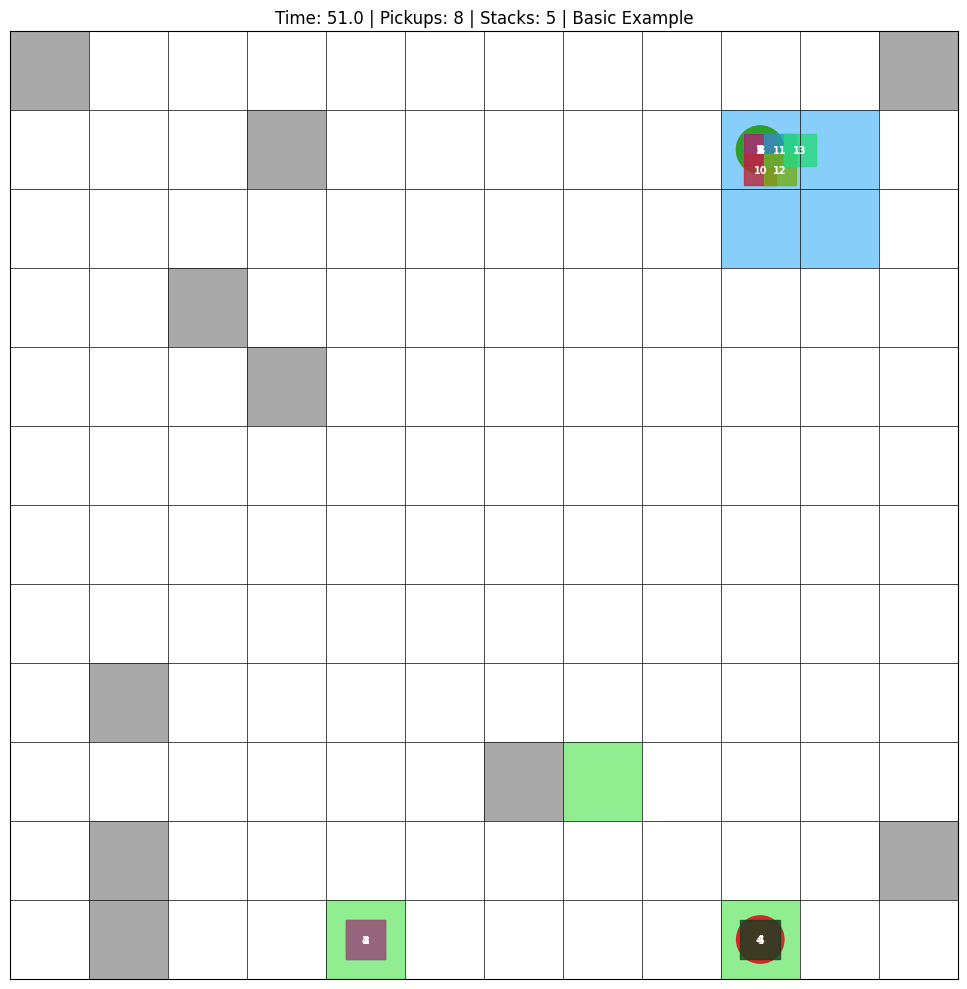

Simulation completed at time 51.0
Total pickups: 8
Total stacks: 5


In [50]:
simulation = WarehouseSimulation(
        grid_size=12,         # Size of the grid
        num_agents=4,         # Number of agents
        num_obstacles=10,     # Number of obstacles
        num_storage_zones=3,  # Number of storage zones
        num_initial_blocks=8, # Initial blocks in the pickup zone
        seed=42               # Random seed for reproducibility
    )
    
# Create a visualizer for this simulation
visualizer = WarehouseVisualizer(simulation)

# Run the simulation for a specific duration
simulation.run(until_time=50.0)

# Render the final state
plt.figure(figsize=(10, 10))
visualizer.render_frame(title_suffix="Basic Example")
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Simulation completed at time {simulation.current_time:.1f}")
print(f"Total pickups: {simulation.stats['total_pickups']}")
print(f"Total stacks: {simulation.stats['total_stacks']}")

## CS Placement

In [ ]:
def gen_charging_stations(layout, n_cs):
    charging_locs = [len(layout.columns) * i // (n_cs + 1) for i in range(1, n_cs + 1)]
    aisle = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -6 if i in charging_locs else -2 for i in range(len(layout.columns))}, index=[1])
    aisle1 = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.columns))}, index=[2])
    line = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -2 if i == 1 else -5 for i in range(len(layout.columns))}, index=[3])
    aisle2 = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -5 if i == 2 else -2 for i in range(len(layout.columns))}, index=[4])
    
    layout_new = pd.concat([layout.iloc[:1], aisle, aisle1, line, aisle2, layout.iloc[1:]]).reset_index(drop=True)
    return layout_new

def gen_charging_stations_left(layout, n_cs):
    # Calculate the positions for charging stations
    charging_locs = [len(layout.index) * i // (n_cs + 1) for i in range(1, n_cs + 1)]
    
    # Create new columns for the charging stations and aisles
    aisle = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -6 if i in charging_locs else -2 for i in range(len(layout.index))})
    aisle1 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    #line = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -2 if i == 1 else -5 for i in range(len(layout.index))})
    # aisle2 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    # aisle3 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    
    # Concatenate the new columns with the existing layout, preserving the structure
    layout_new = pd.concat([
        layout.iloc[:, :1],  # First column of original layout
        pd.DataFrame({0: aisle, 1: aisle1}),  # New columns
        layout.iloc[:, 2:]  # Rest of the original layout
    ], axis=1)
    
    # Reset and rename the columns
    layout_new.columns = range(len(layout_new.columns))
    
    return layout_new

if use_case == "wepastacks":
    layout_new = gen_charging_stations(layout, 3)
elif use_case == "crossstacks":
    layout_new = gen_charging_stations_left(layout, 2)
elif use_case == "minislap":
    layout_new = gen_charging_stations_left(layout, 1)
plt.imshow(layout_new)

In [ ]:
layout_new.to_csv(f"../1_environment/slapstack/slapstack/use_cases/{use_case}_bm/1_layout.csv", header=None, index=False)

In [ ]:
from numpy import genfromtxt

unit_dist = 1.4
use_case = "wepastacks" 
layout_path = f"../1_environment/slapstack/slapstack/use_cases/{use_case}/1_layout.csv"
layout = genfromtxt(layout_path, delimiter=',')
layout = layout.astype(int)
shape = layout.shape
if layout[0, 0] != -1:
    layout[0, 0] = -1
    data = np.transpose(layout)
else:
    data = np.delete(layout, shape[1] - 1, axis=1)
    
rows, cols = layout.shape
storage_positions = set()
source_docks = set()
sink_docks = set()

# Process each cell in the layout
for row in range(rows):
    for col in range(cols):
        value = layout[row, col]
        
        # Calculate coordinates (origin at top-left corner)
        x = col * unit_dist
        y = row * unit_dist
        
        if value == 0:
            storage_positions.add((x, y))
        elif value == -3:
            source_docks.add((x, y))
        elif value == -4:
            sink_docks.add((x, y))

In [ ]:
source_docks

In [ ]:
sink_docks

In [ ]:
# Don't create intermediate JSON strings
storage_pos = [{"x": round(x, 2), "y": round(y, 2)} for x, y in sorted(storage_positions)]
source_pos = [{"x": round(x, 2), "y": round(y, 2)} for x, y in sorted(source_docks)]
sink_pos = [{"x": round(x, 2), "y": round(y, 2)} for x, y in sorted(sink_docks)]

# Save directly to files without intermediate json.dumps()
with open('storage_positions.json', 'w') as f:
    json.dump({"storage_positions": storage_pos}, f, indent=2)
with open('source_dock_positions.json', 'w') as f:
    json.dump({"source_dock_positions": source_pos}, f, indent=2)
with open('sink_dock_positions.json', 'w') as f:
    json.dump({"sink_dock_positions": sink_pos}, f, indent=2)

In [ ]:
import json
root_dir_partitions = '../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/partitions/'

def load_partitions_data(path):
    col_orders = ["order", "SKU", "arrival", "dock", "batch", "week"]
    col_fill_lvl = ["SKU", "amount"]
    orders = json.load(open(f'{path}_orders.json')) 
    fill_level = json.load(open(f'{path}_fill_lvl.json')) 
    return (pd.DataFrame(columns=col_orders, data=orders), 
            pd.DataFrame.from_dict(data=fill_level, orient='index'))

orders_dict = dict({})
fill_lvls_dict = dict({})
n_partitions = 20

for pt_idx in range(n_partitions):
    orders_dict[pt_idx] = []
    fill_lvls_dict[pt_idx] = []
    orders, fill_level = load_partitions_data(f'{root_dir_partitions}{pt_idx}_partition')
    if orders is not None:
        orders_dict[pt_idx].append(orders)
    if fill_level is not None:
        fill_lvls_dict[pt_idx].append(fill_level)
        
total_locations = 19512
fill_lvls = []
for pt_idx in range(n_partitions):
    fill_lvls.append(float((fill_lvls_dict[pt_idx][0].sum() / total_locations) * 100))
    
def agg_overall_stocklevels(row):
    global current_stock_overall
    
    #update current_stock_overall
    current_level = row['amount_change'] + current_stock_overall
    current_stock_overall = current_level
    return current_level

def convert_time(row):
    return pd.Timestamp(row["arrival"], unit='s') 

total_locations = 19512

for idx in orders_dict.keys():
    current_partition = orders_dict[idx][0]
    current_partition.loc[current_partition['order'] == 'retrieval', 'amount_change'] = -1
    current_partition.loc[current_partition['order'] == 'delivery', 'amount_change'] = 1

    current_stock_overall = fill_lvls_dict[idx][0].sum()
    
    current_partition['current_stock_overall'] = current_partition.apply(agg_overall_stocklevels, axis = 1)
    current_partition["fill_level"] = current_partition["current_stock_overall"] / total_locations
    
    current_partition["arrival_datetime"] = current_partition.apply(lambda x: convert_time(x), axis=1)
    current_partition["date"] = current_partition["arrival_datetime"].apply(lambda x: x.strftime("%Y-%m-%d"))
    current_partition["day"] = current_partition["arrival_datetime"].apply(lambda x: x.weekday())
    current_partition["hour"] = current_partition["arrival_datetime"].apply(lambda x: x.hour)
    current_partition["partition"] = idx
    try:
        assert  fill_lvls_dict[idx+1][0].sum()[0] == current_partition.iloc[-1]["current_stock_overall"]
    except KeyError:
        print("Key")